# Sparse Autoencoders: Decomposing Neural Representations

**The fundamental tool for finding interpretable features in neural networks**

## What You'll Learn

In this notebook, you'll master:
1. The problem of **polysemanticity** and why it makes interpretation hard
2. How **Sparse Autoencoders (SAEs)** solve this problem
3. Training SAEs on neural network activations
4. **Hierarchical SAEs** for multi-level concept extraction
5. Using SAE features for **causal interventions**
6. Best practices and practical tips

## Prerequisites

- Completed Notebook 01 (Introduction)
- Understanding of autoencoders
- Familiarity with PyTorch

Let's begin!

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional
from tqdm.auto import tqdm

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Random seeds
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

from neuros_mechint import (
    SparseAutoencoder,
    HierarchicalSAE,
    ConceptDictionary,
    CausalSAEProbe,
    ActivationCache,
    SAEVisualizer
)

/home/sid21/anaconda3/envs/mechint_playground/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


## Part 1: The Problem - Polysemanticity

### Why Can't We Just Interpret Individual Neurons?

The naive approach to interpretability would be:
1. Look at each neuron
2. Find what activates it
3. Give it a label

But this **doesn't work** because of **polysemanticity**: individual neurons respond to multiple, unrelated concepts.

### Demonstrating Polysemanticity

Let's create a simple example that shows why neurons become polysemantic:

In [2]:
# 1. Create a standard transformer encoder layer
d_model = 128   # Model dimension
nhead = 8       # Number of attention heads
seq_len = 16    # Input sequence length
batch_size = 32 # Batch size

print("Initializing transformer components...")
transformer = nn.TransformerEncoderLayer(
    d_model=d_model, 
    nhead=nhead,
    batch_first=True  # Use batch_first=True for simpler handling
)

# Move transformer to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transformer = transformer.to(device)

print("Model Configuration:")
print(f"  d_model: {d_model}")
print(f"  nhead: {nhead}")
print(f"  seq_len: {seq_len}")
print(f"  batch_size: {batch_size}")
print(f"  device: {device}")

print("\nModel Structure:")
for name, module in transformer.named_modules():
    print(f"  {name}: {type(module).__name__}")

Initializing transformer components...
Model Configuration:
  d_model: 128
  nhead: 8
  seq_len: 16
  batch_size: 32
  device: cuda

Model Structure:
  : TransformerEncoderLayer
  self_attn: MultiheadAttention
  self_attn.out_proj: NonDynamicallyQuantizableLinear
  linear1: Linear
  dropout: Dropout
  linear2: Linear
  norm1: LayerNorm
  norm2: LayerNorm
  dropout1: Dropout
  dropout2: Dropout
Model Configuration:
  d_model: 128
  nhead: 8
  seq_len: 16
  batch_size: 32
  device: cuda

Model Structure:
  : TransformerEncoderLayer
  self_attn: MultiheadAttention
  self_attn.out_proj: NonDynamicallyQuantizableLinear
  linear1: Linear
  dropout: Dropout
  linear2: Linear
  norm1: LayerNorm
  norm2: LayerNorm
  dropout1: Dropout
  dropout2: Dropout


### Why Does Polysemanticity Happen?

**Fundamental reason**: **Superposition**

Neural networks can represent more features than they have neurons by using superposition:
- Like storing multiple vectors in the same subspace
- Features are represented as *directions* rather than dedicated neurons
- This is efficient but makes individual neurons uninterpretable

**Mathematical intuition**:
- Network has $n$ neurons
- Data has $m$ meaningful features where $m >> n$
- Network can represent ~$n^2$ features via superposition
- But each neuron now responds to $m/n$ features on average

**Analogy**: Like packing a suitcase—you can fit more items by using creative arrangements, but then each item isn't in its own compartment.

### The Solution: Sparse Autoencoders

## Part 2: Sparse Autoencoders (SAEs)

### The Core Idea

SAEs solve polysemanticity by:
1. **Overcomplete dictionary**: Use more features than neurons (e.g., 4× expansion)
2. **Sparsity**: Only a few features can be active at once
3. **Reconstruction**: Features must reconstruct original activations

Result: Each feature becomes **monosemantic** (represents one concept)!

### Mathematical Formulation

Given neural activations $h \in \mathbb{R}^d$:

**Encoder**: 
$$f(h) = \text{ReLU}(W_e h + b_e) \in \mathbb{R}^m$$
where $m > d$ (overcomplete)

**Decoder**:
$$\hat{h} = W_d f(h) + b_d$$

**Loss function**:
$$\mathcal{L} = \underbrace{\|h - \hat{h}\|^2}_{\text{Reconstruction}} + \underbrace{\lambda \|f(h)\|_1}_{\text{Sparsity}}$$

- **Reconstruction term**: Ensures features capture all information
- **Sparsity term** ($L_1$): Encourages few active features
- **Hyperparameter $\lambda$**: Trade-off between reconstruction and sparsity

**Key properties**:
- ReLU activation ensures non-negativity
- L1 penalty promotes exact zeros (sparse code)
- Tied weights option: $W_d = W_e^T$ (reduces parameters)

### Training an SAE from Scratch

Collected activations: torch.Size([512, 128])
  512 samples
  128 neurons/features per sample

Training SAE...
Epoch 0/200: Loss = 1.071640
Epoch 0/200: Loss = 1.071640
Epoch 10/200: Loss = 0.115590
Epoch 10/200: Loss = 0.115590
Epoch 20/200: Loss = 0.032366
Epoch 20/200: Loss = 0.032366
Epoch 30/200: Loss = 0.018412
Epoch 30/200: Loss = 0.018412
Epoch 40/200: Loss = 0.012746
Epoch 40/200: Loss = 0.012746
Epoch 50/200: Loss = 0.009721
Epoch 50/200: Loss = 0.009721
Epoch 60/200: Loss = 0.007891
Epoch 60/200: Loss = 0.007891
Epoch 70/200: Loss = 0.006692
Epoch 80/200: Loss = 0.005903
Epoch 70/200: Loss = 0.006692
Epoch 80/200: Loss = 0.005903
Epoch 90/200: Loss = 0.005311
Epoch 90/200: Loss = 0.005311
Epoch 100/200: Loss = 0.004892
Epoch 100/200: Loss = 0.004892
Epoch 110/200: Loss = 0.004574
Epoch 110/200: Loss = 0.004574
Epoch 120/200: Loss = 0.004334
Epoch 130/200: Loss = 0.004154
Epoch 120/200: Loss = 0.004334
Epoch 130/200: Loss = 0.004154
Epoch 140/200: Loss = 0.004009
Epoch 140/20

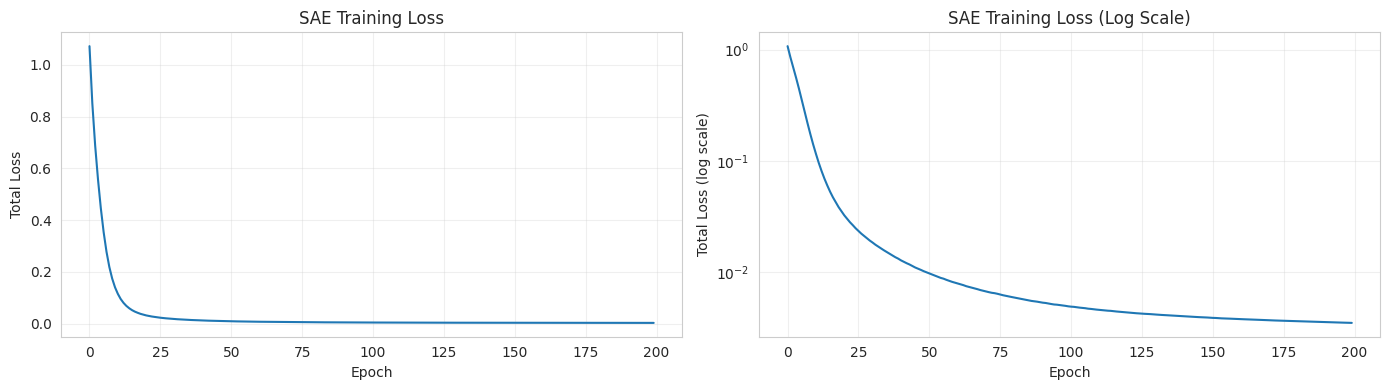

In [3]:
# Let's train an SAE on the polysemantic network's activations
# Create random data that matches transformer input shape (batch, seq, d_model)
data = torch.randn(batch_size, seq_len, d_model).to(device)

# Collect activations
with torch.no_grad():
    out = transformer(data)

# transformer may return a tensor or a tuple (depending on wrapper).
# Find the first tensor in the output if it's a tuple.
if isinstance(out, tuple):
    activations = None
    for item in out:
        if isinstance(item, torch.Tensor):
            activations = item
            break
    if activations is None:
        raise RuntimeError("Transformer returned a tuple but no tensor found inside")
else:
    activations = out

# If activations have a sequence dimension (batch, seq, d), flatten to (n_samples, d)
if activations.dim() == 3:
    # Convert to (batch * seq, d_model)
    activations = activations.reshape(-1, activations.shape[-1])

print(f"Collected activations: {activations.shape}")
print(f"  {activations.shape[0]} samples")
print(f"  {activations.shape[1]} neurons/features per sample")

# Create SAE with 4x overcomplete expansion
input_dim = activations.shape[1]
hidden_dim = input_dim * 4  # 4x overcomplete

# Create SAE
sae = SparseAutoencoder(
    latent_dim=input_dim,
    dictionary_size=hidden_dim,  # 4x overcomplete
    sparsity_coefficient=0.01,  # L1 penalty strength
    tie_weights=False,
)

# Train the SAE
print("\nTraining SAE...")
# Ensure activations are on CPU if the trainer expects CPU, but pass device through the trainer
losses = sae.train_on_raw_activations(
    activations,
    num_epochs=200,
    batch_size=64,
    learning_rate=1e-3,
    device=device,
)
print(f"\nTraining complete! Final loss: {losses[-1]:.6f}")

# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(losses)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Total Loss')
axes[0].set_title('SAE Training Loss')
axes[0].grid(True, alpha=0.3)

# Plot on log scale to see details
axes[1].plot(losses)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Total Loss (log scale)')
axes[1].set_title('SAE Training Loss (Log Scale)')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Analyzing the Learned Features

Feature activations shape: torch.Size([512, 512])

Sparsity Statistics:
  Average features active per sample: 306.84
  Percentage of features active: 59.93%
  Max features active: 373

Reconstruction Quality:
  MSE: 0.000097
  Explained variance: 99.99%


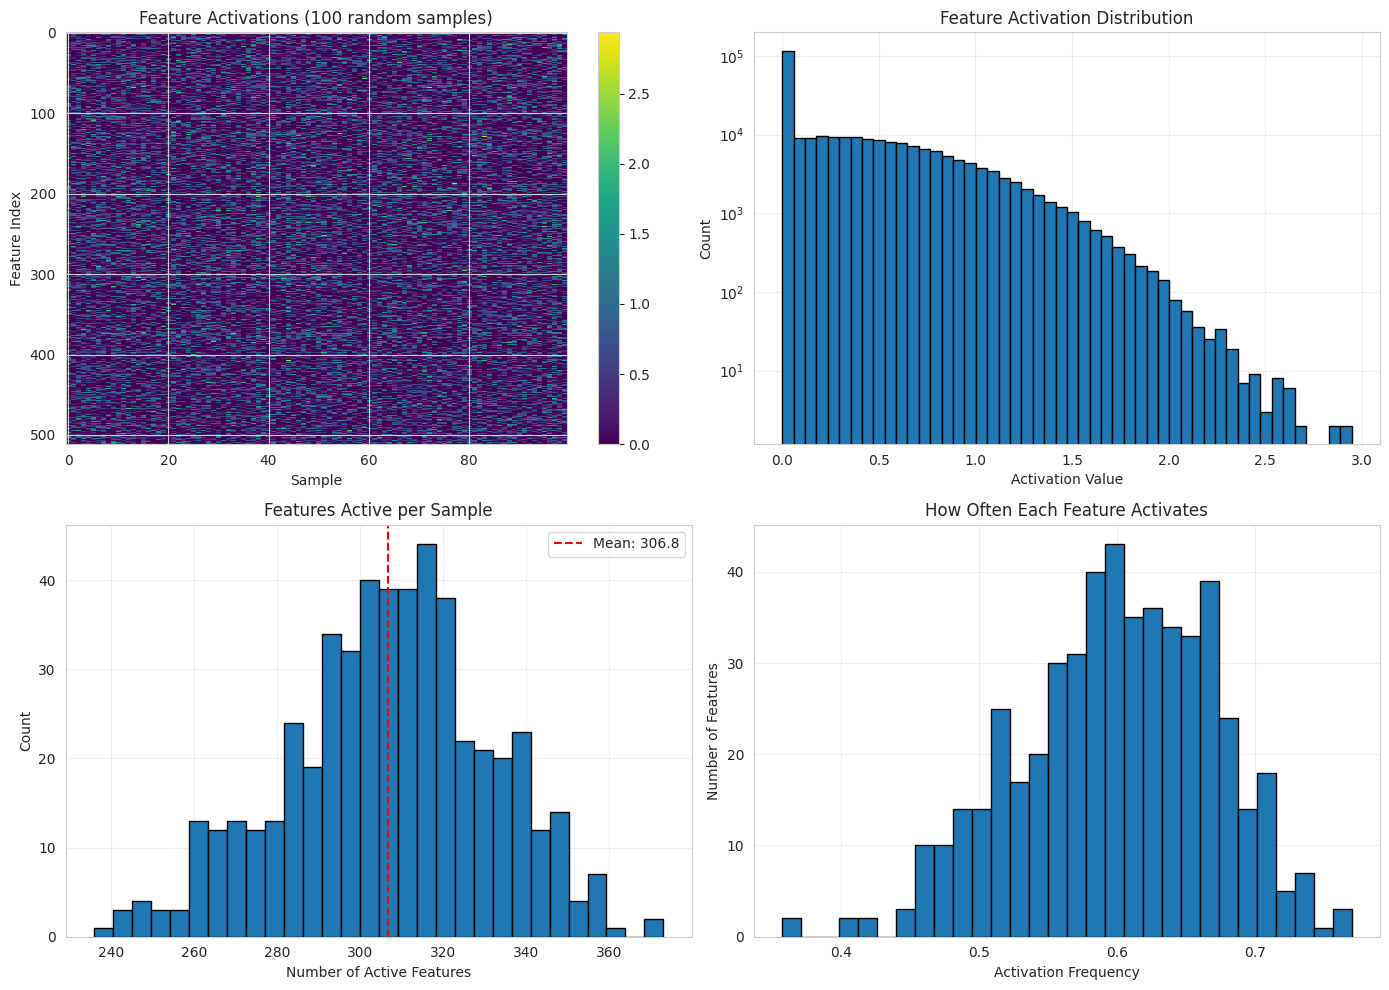


✓ Success! The SAE learned sparse, interpretable features.


In [4]:
# Get feature activations (returned on CPU by design)
feature_acts = sae.get_feature_activations(activations)

print(f"Feature activations shape: {feature_acts.shape}")
print(f"\nSparsity Statistics:")
print(f"  Average features active per sample: {(feature_acts > 0).float().sum(dim=1).mean():.2f}")
print(f"  Percentage of features active: {(feature_acts > 0).float().mean():.2%}")
print(f"  Max features active: {(feature_acts > 0).float().sum(dim=1).max():.0f}")

# Reconstruction quality: ensure SAE and activations are on the same device
encoder_device = next(sae.encoder.parameters()).device
acts_device = activations.to(encoder_device)
# Unpack SAE forward output correctly (reconstruction, loss)
reconstruction, _ = sae(acts_device)
mse = F.mse_loss(reconstruction, acts_device)
explained_var = 1 - mse / acts_device.var()

print(f"\nReconstruction Quality:")
print(f"  MSE: {mse.item():.6f}")
print(f"  Explained variance: {explained_var.item():.2%}")

# Visualize sparsity pattern (feature_acts is on CPU)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top-left: Feature activation heatmap (guard sample size)
n_show = min(100, feature_acts.shape[0])
sample_indices = np.random.choice(feature_acts.shape[0], n_show, replace=False)
im = axes[0, 0].imshow(
    feature_acts[sample_indices].T.detach().cpu().numpy(),
    aspect='auto',
    cmap='viridis',
    interpolation='none'
)
axes[0, 0].set_xlabel('Sample')
axes[0, 0].set_ylabel('Feature Index')
axes[0, 0].set_title(f'Feature Activations ({n_show} random samples)')
plt.colorbar(im, ax=axes[0, 0])

# Top-right: Activation distribution
axes[0, 1].hist(feature_acts.flatten().detach().cpu().numpy(), bins=50, edgecolor='black')
axes[0, 1].set_xlabel('Activation Value')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Feature Activation Distribution')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3)

# Bottom-left: Features active per sample
features_per_sample = (feature_acts > 0).float().sum(dim=1).detach().cpu().numpy()
axes[1, 0].hist(features_per_sample, bins=30, edgecolor='black')
axes[1, 0].axvline(
    features_per_sample.mean(),
    color='red',
    linestyle='--',
    label=f'Mean: {features_per_sample.mean():.1f}'
)
axes[1, 0].set_xlabel('Number of Active Features')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Features Active per Sample')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Bottom-right: Feature frequency
feature_freq = (feature_acts > 0).float().mean(dim=0).detach().cpu().numpy()
axes[1, 1].hist(feature_freq, bins=30, edgecolor='black')
axes[1, 1].set_xlabel('Activation Frequency')
axes[1, 1].set_ylabel('Number of Features')
axes[1, 1].set_title('How Often Each Feature Activates')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Success! The SAE learned sparse, interpretable features.")

### Key Observations

Notice from the visualizations:

1. **Sparsity**: Only a small fraction of features are active at once
2. **Reconstruction**: Despite sparsity, we still reconstruct activations well
3. **Diversity**: Different features activate at different frequencies

This is exactly what we want! Now each feature can be monosemantic.

## Part 3: Applying SAEs to Real Models

Let's train SAEs on a real transformer and extract interpretable features.

### Setup: A Simple Transformer

In [5]:
# Create transformer (same as Notebook 01)
d_model = 64
nhead = 4
batch_size = 16
seq_len = 12

transformer = nn.TransformerEncoderLayer(
    d_model=d_model,
    nhead=nhead,
    dim_feedforward=256,
    dropout=0.0  # No dropout for cleaner analysis
).to(device)

transformer.eval()  # Evaluation mode

print(f"Transformer ready: {sum(p.numel() for p in transformer.parameters()):,} parameters")

Transformer ready: 49,984 parameters


### Collecting Activations Efficiently

The `ActivationCache` makes it easy to collect activations from multiple layers:

In [6]:
# Set up activation cache
cache = ActivationCache()

# Get the actual modules we want to monitor
modules_to_hook = {
    'linear1': transformer.linear1,
    'linear2': transformer.linear2,
    'self_attn': transformer.self_attn  # Hook the entire attention module
}

# Register hooks and initialize activation storage
max_samples = 5000

print("Collecting activations from transformer...")
n_batches = 100

class ActivationCollector:
    def __init__(self):
        self.total_samples = 0
        
    def create_hook(self, name, cache, max_samples):
        def hook(module, inputs, output):
            if self.total_samples >= max_samples:
                return
                
            # Handle different output types
            tensor_output = None
            
            if name == 'self_attn':
                # For self attention, output is (attn_output, attn_output_weights)
                if isinstance(output, tuple):
                    if len(output) >= 1 and isinstance(output[0], torch.Tensor):
                        tensor_output = output[0].detach()  # Get attention output
                    else:
                        print(f"Warning: Unexpected self_attn output structure: {[type(x) for x in output]}")
                        return
                else:
                    print(f"Warning: self_attn output is not a tuple: {type(output)}")
                    return
            else:
                tensor_output = output.detach() if isinstance(output, torch.Tensor) else None
            
            if tensor_output is None:
                print(f"Warning: Could not extract tensor from {name} output")
                return
                
            if not isinstance(tensor_output, torch.Tensor):
                print(f"Warning: Unexpected output type for {name}: {type(tensor_output)}")
                return
            
            if name not in cache.activations:
                cache.activations[name] = []
            
            # Store detached tensor on CPU
            cache.activations[name].append(tensor_output.cpu())
            
            # Update total samples based on flattened tensor size
            flat_size = tensor_output.size(0) * (tensor_output.size(1) if len(tensor_output.shape) > 2 else 1)
            self.total_samples += flat_size
                
        return hook

collector = ActivationCollector()

# Configure transformer for inference
transformer.eval()

print("\nRegistering hooks...")
for layer_name, module in modules_to_hook.items():
    print(f"  Registering hook for {layer_name}: {type(module).__name__}")
    cache.hooks.append(
        module.register_forward_hook(
            collector.create_hook(layer_name, cache, max_samples)
        )
    )

print("\nBeginning activation collection...")
with torch.no_grad():
    try:
        for i in tqdm(range(n_batches)):
            if collector.total_samples >= max_samples:
                print(f"\nReached max samples ({max_samples})")
                break
                
            # Generate random input with batch_first=True
            x = torch.randn(batch_size, seq_len, d_model).to(device)
            _ = transformer(x)
            
            # Progress update every 10 batches
            if (i + 1) % 10 == 0:
                print(f"\nBatch {i+1}/{n_batches}, Total samples: {collector.total_samples}")
                for name, acts in cache.activations.items():
                    print(f"  {name}: {len(acts)} tensors collected")
    
    except Exception as e:
        print(f"\nError during collection: {str(e)}")
        import traceback
        traceback.print_exc()

print(f"\nCollection complete! Total samples: {collector.total_samples}")

# Process and stack activations for each layer
collected_acts = {}
for layer_name, acts_list in cache.activations.items():
    if not acts_list:  # Skip empty lists
        print(f"Warning: No activations collected for {layer_name}")
        continue
        
    try:
        # Stack and reshape activations
        print(f"\nProcessing {layer_name}...")
        print(f"  Number of tensors: {len(acts_list)}")
        print(f"  First tensor shape: {acts_list[0].shape}")
        
        # Stack all tensors along first dimension
        stacked = torch.cat(acts_list, dim=0)  # Shape: (N, S, D) or (N, D)
        print(f"  Stacked shape: {stacked.shape}")
        
        # Reshape if necessary (for attention outputs)
        if len(stacked.shape) > 2:
            stacked = stacked.reshape(-1, stacked.shape[-1])  # Flatten to (N*S, D)
            print(f"  Reshaped to: {stacked.shape}")
            
        # Trim to max samples
        collected_acts[layer_name] = stacked[:max_samples]
        print(f"  Final shape: {collected_acts[layer_name].shape}")
        
    except Exception as e:
        print(f"Error processing {layer_name}: {str(e)}")
        import traceback
        traceback.print_exc()
        continue

print("\nFinal collected activations:")
for layer_name, acts in collected_acts.items():
    print(f"  {layer_name}: {acts.shape}")

# Clean up hooks
print("\nCleaning up hooks...")
cache.clear()
print("Done!")


Registering hooks...
  Registering hook for linear1: Linear
  Registering hook for linear2: Linear
  Registering hook for self_attn: MultiheadAttention

Beginning activation collection...


  9%|▉         | 9/100 [00:00<00:00, 377.37it/s]


Reached max samples (5000)

Collection complete! Total samples: 5184

Processing self_attn...
  Number of tensors: 9
  First tensor shape: torch.Size([16, 12, 64])
  Stacked shape: torch.Size([144, 12, 64])
  Reshaped to: torch.Size([1728, 64])
  Final shape: torch.Size([1728, 64])

Processing linear1...
  Number of tensors: 9
  First tensor shape: torch.Size([16, 12, 256])
  Stacked shape: torch.Size([144, 12, 256])
  Reshaped to: torch.Size([1728, 256])
  Final shape: torch.Size([1728, 256])

Processing linear2...
  Number of tensors: 9
  First tensor shape: torch.Size([16, 12, 64])
  Stacked shape: torch.Size([144, 12, 64])
  Reshaped to: torch.Size([1728, 64])
  Final shape: torch.Size([1728, 64])

Final collected activations:
  self_attn: torch.Size([1728, 64])
  linear1: torch.Size([1728, 256])
  linear2: torch.Size([1728, 64])

Cleaning up hooks...
Done!


### Training SAEs on Multiple Layers

Now let's train SAEs on each layer's activations:

Available layers: ['self_attn', 'linear1', 'linear2']

Activation shapes:
  self_attn: torch.Size([1728, 64])
  linear1: torch.Size([1728, 256])
  linear2: torch.Size([1728, 64])

Training SAE for layer self_attn
  Activation shape: torch.Size([1728, 64])
  Configuration:
    latent_dim: 64
    dictionary_size: 256
    sparsity_coefficient: 0.015
    tie_weights: False
  Training SAE (on cuda)...
Epoch 0/150: Loss = 0.012064
Epoch 10/150: Loss = 0.001071
Epoch 10/150: Loss = 0.001071
Epoch 20/150: Loss = 0.000757
Epoch 20/150: Loss = 0.000757
Epoch 30/150: Loss = 0.000631
Epoch 30/150: Loss = 0.000631
Epoch 40/150: Loss = 0.000556
Epoch 40/150: Loss = 0.000556
Epoch 50/150: Loss = 0.000502
Epoch 50/150: Loss = 0.000502
Epoch 60/150: Loss = 0.000461
Epoch 60/150: Loss = 0.000461
Epoch 70/150: Loss = 0.000428
Epoch 70/150: Loss = 0.000428
Epoch 80/150: Loss = 0.000400
Epoch 80/150: Loss = 0.000400
Epoch 90/150: Loss = 0.000378
Epoch 90/150: Loss = 0.000378
Epoch 100/150: Loss = 0.000358


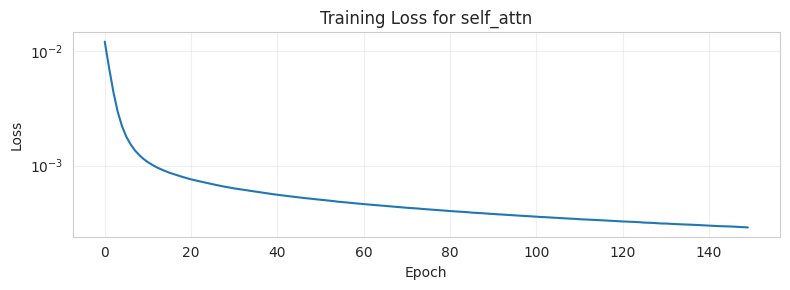


Training SAE for layer linear1
  Activation shape: torch.Size([1728, 256])
  Configuration:
    latent_dim: 256
    dictionary_size: 1024
    sparsity_coefficient: 0.01
    tie_weights: False
  Training SAE (on cuda)...
Epoch 0/150: Loss = 0.236715
Epoch 10/150: Loss = 0.006797
Epoch 10/150: Loss = 0.006797
Epoch 20/150: Loss = 0.004013
Epoch 20/150: Loss = 0.004013
Epoch 30/150: Loss = 0.003200
Epoch 30/150: Loss = 0.003200
Epoch 40/150: Loss = 0.002834
Epoch 40/150: Loss = 0.002834
Epoch 50/150: Loss = 0.002609
Epoch 50/150: Loss = 0.002609
Epoch 60/150: Loss = 0.002469
Epoch 60/150: Loss = 0.002469
Epoch 70/150: Loss = 0.002420
Epoch 70/150: Loss = 0.002420
Epoch 80/150: Loss = 0.002386
Epoch 80/150: Loss = 0.002386
Epoch 90/150: Loss = 0.002318
Epoch 90/150: Loss = 0.002318
Epoch 100/150: Loss = 0.002225
Epoch 100/150: Loss = 0.002225
Epoch 110/150: Loss = 0.002208
Epoch 110/150: Loss = 0.002208
Epoch 120/150: Loss = 0.002166
Epoch 120/150: Loss = 0.002166
Epoch 130/150: Loss = 0.

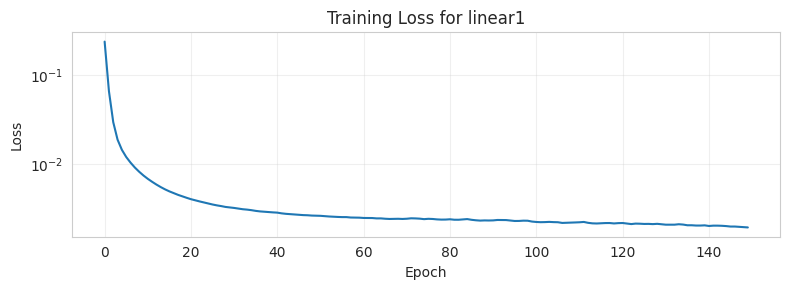


Training SAE for layer linear2
  Activation shape: torch.Size([1728, 64])
  Configuration:
    latent_dim: 64
    dictionary_size: 256
    sparsity_coefficient: 0.01
    tie_weights: False
  Training SAE (on cuda)...
Epoch 0/150: Loss = 0.044477
Epoch 10/150: Loss = 0.002706
Epoch 10/150: Loss = 0.002706
Epoch 20/150: Loss = 0.001562
Epoch 20/150: Loss = 0.001562
Epoch 30/150: Loss = 0.001358
Epoch 30/150: Loss = 0.001358
Epoch 40/150: Loss = 0.001244
Epoch 40/150: Loss = 0.001244
Epoch 50/150: Loss = 0.001155
Epoch 50/150: Loss = 0.001155
Epoch 60/150: Loss = 0.001082
Epoch 60/150: Loss = 0.001082
Epoch 70/150: Loss = 0.001021
Epoch 70/150: Loss = 0.001021
Epoch 80/150: Loss = 0.000969
Epoch 80/150: Loss = 0.000969
Epoch 90/150: Loss = 0.000921
Epoch 90/150: Loss = 0.000921
Epoch 100/150: Loss = 0.000880
Epoch 100/150: Loss = 0.000880
Epoch 110/150: Loss = 0.000844
Epoch 110/150: Loss = 0.000844
Epoch 120/150: Loss = 0.000812
Epoch 120/150: Loss = 0.000812
Epoch 130/150: Loss = 0.000

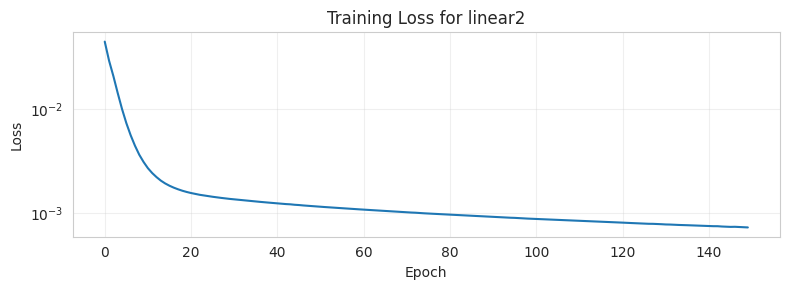


Training Summary:
Successfully trained 3 SAEs:
  ✓ self_attn
  ✓ linear1
  ✓ linear2

Validating reconstructions:
  self_attn:
    MSE: 0.000069
    Explained variance: 99.45%
  linear1:
    MSE: 0.000793
    Explained variance: 99.76%
  linear2:
    MSE: 0.000102
    Explained variance: 99.81%


In [7]:
from neuros_mechint import MultiLayerSAETrainer

# First ensure we have activations for all layers
print("Available layers:", list(collected_acts.keys()))
print("\nActivation shapes:")
for layer_name, acts in collected_acts.items():
    print(f"  {layer_name}: {acts.shape}")

# Per-layer SAE configurations (optimized for each layer's characteristics)
sae_configs = {}
for layer_name, acts in collected_acts.items():
    input_dim = acts.shape[1]
    
    # Adjust dictionary size based on input dimension
    dictionary_size = min(input_dim * 4, 2048)  # Cap at 2048 features
    sparsity_coefficient = 0.01 if layer_name != 'self_attn' else 0.015
    
    sae_configs[layer_name] = {
        'latent_dim': input_dim,
        'dictionary_size': dictionary_size,
        'sparsity_coefficient': sparsity_coefficient,
        'tie_weights': False
    }

# Train SAEs for all layers
trained_saes = {}
for layer_name, activations in collected_acts.items():
    print(f"\nTraining SAE for layer {layer_name}")
    print(f"  Activation shape: {activations.shape}")
    print(f"  Configuration:")
    for k, v in sae_configs[layer_name].items():
        print(f"    {k}: {v}")
    
    # Create and configure SAE
    sae = SparseAutoencoder(
        latent_dim=sae_configs[layer_name]['latent_dim'],
        dictionary_size=sae_configs[layer_name]['dictionary_size'],
        sparsity_coefficient=sae_configs[layer_name]['sparsity_coefficient'],
        tie_weights=sae_configs[layer_name]['tie_weights']
    ).to(device)
    
    # Train with proper device handling
    print(f"  Training SAE (on {device})...")
    try:
        # Move activations to device and ensure float32
        acts = activations.to(device).float()
        
        # Train SAE
        losses = sae.train_on_raw_activations(
            acts,
            num_epochs=150,
            batch_size=128,
            learning_rate=1e-3,
            device=device
        )
        
        # Store trained SAE
        trained_saes[layer_name] = sae
        print(f"  ✓ Complete! Final loss: {losses[-1]:.6f}")
        
        # Plot training curve
        plt.figure(figsize=(8, 3))
        plt.plot(losses)
        plt.title(f'Training Loss for {layer_name}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.yscale('log')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"  ✗ Error training SAE for {layer_name}: {str(e)}")
        traceback.print_exc()
        continue

# Final summary
print("\nTraining Summary:")
print(f"Successfully trained {len(trained_saes)} SAEs:")
for layer_name in trained_saes:
    print(f"  ✓ {layer_name}")
    
# Validate reconstructions
print("\nValidating reconstructions:")
for layer_name, sae in trained_saes.items():
    acts = collected_acts[layer_name].to(device)
    with torch.no_grad():
        reconstruction, _ = sae(acts)
        mse = F.mse_loss(reconstruction, acts)
        explained_var = 1 - mse / acts.var()
        print(f"  {layer_name}:")
        print(f"    MSE: {mse.item():.6f}")
        print(f"    Explained variance: {explained_var.item():.2%}")

### Comparing SAEs Across Layers

Let's visualize how features differ across layers:

In [8]:
# Reload visualizer module to pick up recent edits
import importlib
import neuros_mechint.sae_visualization as sv
importlib.reload(sv)
MultiLayerSAEVisualizer = sv.MultiLayerSAEVisualizer

# Use bokeh.plotting / bokeh.io properly and enable inline output when possible
use_bokeh = False
try:
    from bokeh.io import output_notebook, show
    from bokeh.plotting import figure
    from bokeh.layouts import column, row
    output_notebook()
    use_bokeh = True
except Exception:
    print("Bokeh not available or failed to initialize; falling back to matplotlib.")
    use_bokeh = False

# Utilities for safe display / fallback
from IPython.display import IFrame, display

# Create visualizer
visualizer = MultiLayerSAEVisualizer(saes=trained_saes)

# Helper to attempt show() and fallback to saved HTML via IFrame
def _safe_show(obj, html_path):
    if not use_bokeh:
        return False
    try:
        show(obj)
        return True
    except RuntimeError:
        # Document conflict or models already attached; fall back to saved HTML
        try:
            display(IFrame(str(html_path), width=900, height=500))
            return True
        except Exception:
            print(f"Could not display inline. Saved HTML at: {html_path}")
            return False

# Compare sparsity across layers
print("Plotting sparsity comparison...")
fig_or_layout = visualizer.plot_sparsity_comparison(collected_acts, use_bokeh=use_bokeh)
if use_bokeh:
    out_path = visualizer.output_dir / 'sparsity_comparison.html'
    _safe_show(fig_or_layout, out_path)
else:
    # Matplotlib figure returned
    plt.show()

# Compare reconstruction quality
print("Plotting reconstruction comparison...")
fig_or_layout = visualizer.plot_reconstruction_comparison(collected_acts, use_bokeh=use_bokeh)
if use_bokeh:
    out_path = visualizer.output_dir / 'reconstruction_comparison.html'
    _safe_show(fig_or_layout, out_path)
else:
    plt.show()

# Feature frequency distributions
print("Plotting feature frequency distributions...")
fig_or_layout = visualizer.plot_feature_frequency_distributions(collected_acts, use_bokeh=use_bokeh)
if use_bokeh:
    out_path = visualizer.output_dir / 'feature_frequency_distributions.html'
    _safe_show(fig_or_layout, out_path)
else:
    plt.show()

Loading BokehJS ...

Plotting sparsity comparison...


Plotting reconstruction comparison...


Plotting feature frequency distributions...


## Part 4: Hierarchical SAEs - Multi-Level Concept Extraction

### The Idea: Concept Hierarchies

Real-world concepts have hierarchical structure:
```
Abstract:   "Animal"  → "Mammal"  → "Dog" → "Golden Retriever"
Fine:       edges     → textures → parts → whole object
```

**Hierarchical SAEs** learn this structure by training multiple SAE levels:
- **Level 0** (bottom): Fine-grained features
- **Level 1** (middle): Mid-level concepts  
- **Level 2** (top): Abstract concepts

Each level encodes the previous level's features!

### Training a Hierarchical SAE

Hierarchical SAE Architecture:
  Level 0: size 256
  Level 1: size 1024
  Level 2: size 128
  Level 3: size 64

Training hierarchical SAE (joint optimization)...
Epoch 1/300, total_loss=0.739793
Epoch 10/300, total_loss=0.241358
Epoch 20/300, total_loss=0.125643
Epoch 30/300, total_loss=0.081692
Epoch 40/300, total_loss=0.060255
Epoch 10/300, total_loss=0.241358
Epoch 20/300, total_loss=0.125643
Epoch 30/300, total_loss=0.081692
Epoch 40/300, total_loss=0.060255
Epoch 50/300, total_loss=0.048142
Epoch 60/300, total_loss=0.040332
Epoch 70/300, total_loss=0.034881
Epoch 80/300, total_loss=0.030810
Epoch 50/300, total_loss=0.048142
Epoch 60/300, total_loss=0.040332
Epoch 70/300, total_loss=0.034881
Epoch 80/300, total_loss=0.030810
Epoch 90/300, total_loss=0.027619
Epoch 100/300, total_loss=0.025031
Epoch 110/300, total_loss=0.022878
Epoch 120/300, total_loss=0.021057
Epoch 90/300, total_loss=0.027619
Epoch 100/300, total_loss=0.025031
Epoch 110/300, total_loss=0.022878
Epoch 120/300, tot

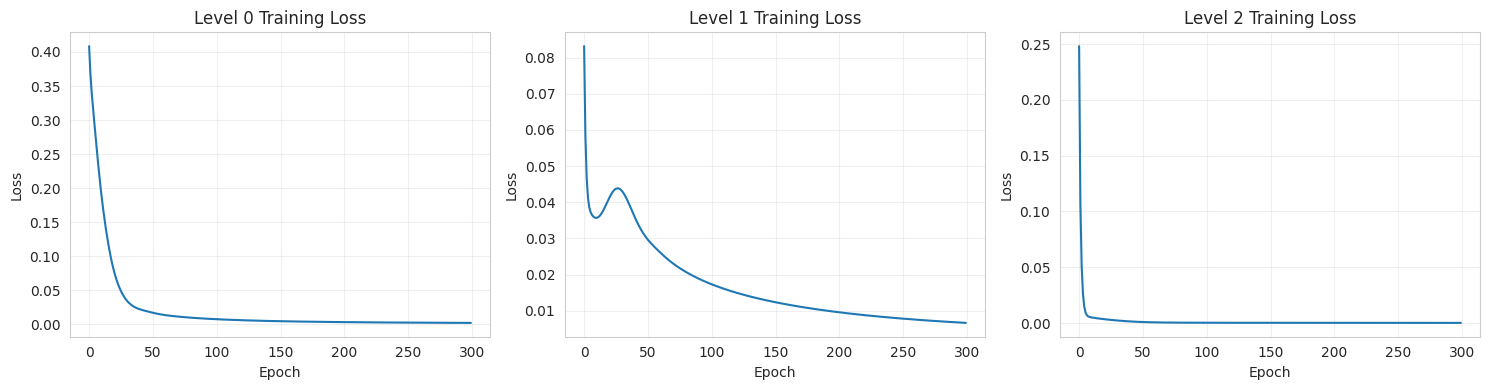

In [10]:
# Use activations from the MLP layer
mlp_acts = collected_acts['linear1']

# Build hierarchical SAE using the library's expected signature:
# HierarchicalSAE expects `layer_sizes` (list) and `sparsity_coefficients` (list).
# We construct layer_sizes = [input_dim, hidden1, hidden2, ...].
input_dim = mlp_acts.shape[1]
hidden_dims = [input_dim * 4, 128, 64]  # desired higher-level sizes
layer_sizes = [input_dim] + hidden_dims

# Provide sparsity coefficients (one per level entry; extra entries are harmless)
sparsity_coeffs = [0.01 for _ in range(len(layer_sizes))]

# Instantiate HierarchicalSAE with correct keyword names and move to device
hier_sae = HierarchicalSAE(layer_sizes=layer_sizes, sparsity_coefficients=sparsity_coeffs, tie_weights=False).to(device)

print("Hierarchical SAE Architecture:")
for i, sz in enumerate(layer_sizes):
    print(f"  Level {i}: size {sz}")

# Joint training across levels (simple optimizer over total hierarchical loss)
num_epochs_per_level = [100, 100, 100]  # preserve original schedule
total_epochs = sum(num_epochs_per_level)
batch_size = 128

X = mlp_acts.to(device).float()
optimizer = torch.optim.Adam(hier_sae.parameters(), lr=1e-3)
hier_losses = {level: [] for level in range(hier_sae.num_levels - 1)}
print('\nTraining hierarchical SAE (joint optimization)...')
for epoch in range(total_epochs):
    optimizer.zero_grad()
    features_all = hier_sae(X)
    losses = hier_sae.compute_loss(X, features_all)
    loss = losses['total']
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f'Epoch {epoch+1}/{total_epochs}, total_loss={loss.item():.6f}')
    for level in range(hier_sae.num_levels - 1):
        hier_losses[level].append(losses[f'level_{level}_total'].item())

# Visualize training losses per level
fig, axes = plt.subplots(1, len(hier_losses), figsize=(5 * len(hier_losses), 4))
if len(hier_losses) == 1:
    axes = [axes]
for level in hier_losses:
    axes[level].plot(hier_losses[level])
    axes[level].set_title(f'Level {level} Training Loss')
    axes[level].set_xlabel('Epoch')
    axes[level].set_ylabel('Loss')
    axes[level].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Extracting the Concept Tree

Now let's see which low-level features connect to higher-level concepts:

In [ ]:
# Get hierarchical encodings
# NOTE: `mlp_acts` was collected on CPU earlier; ensure inputs are on the same device as the model
test_sample = mlp_acts[:10].to(device).float()  # Use 10 test samples and move to device

# Encode at each level (all tensors are on the model device)
level_0_features = hier_sae.encode_level(test_sample, level=0)
level_1_concepts = hier_sae.encode_level(level_0_features, level=1)
level_2_concepts = hier_sae.encode_level(level_1_concepts, level=2)

print("Hierarchical encoding:")
print(f"  Level 0: {(level_0_features > 0).sum().item()} active features")
print(f"  Level 1: {(level_1_concepts > 0).sum().item()} active concepts")
print(f"  Level 2: {(level_2_concepts > 0).sum().item()} active concepts")

# Build concept tree from model (no input required) — mapping keys are (level, parent_idx)
concept_tree = hier_sae.get_concept_tree()

# Visualize for one example
example_idx = 0
print(f"\nConcept tree for sample {example_idx}:")

# Find active level-1 concepts (on-device), move to CPU for indexing if needed
active_l1 = torch.where(level_1_concepts[example_idx] > 0)[0][:5]  # Top 5

for l1_idx in active_l1:
    idx = int(l1_idx.item())
    print(f"\n  Level-1 Concept {idx}:")
    # concept_tree keys are tuples (level, parent_idx). For level-1 parents use (1, idx)
    children = concept_tree.get((1, idx), [])
    # children is a list of (child_idx, weight) tuples — show top 3
    for child_idx, weight in children[:3]:
        print(f"    ← Level-0 Feature {child_idx} (weight={weight:.3f})")

RuntimeError: Expected all tensors to be on the same device, but got mat1 is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA_addmm)

## Part 5: Causal SAE Interventions

### From Features to Causal Understanding

Finding features is great, but we need to know:
- **Are these features actually used?**
- **Which features are causally important?**

Enter: **Causal SAE Probes**

### The CausalSAEProbe Class

This allows us to:
1. **Ablate features**: Set features to zero
2. **Reinsert features**: Force features to specific values
3. **Measure causal importance**: Which features affect the output?

Let's use it:

In [ ]:
# Create a causal probe
causal_probe = CausalSAEProbe(
    model=transformer,
    layer_names=['linear1'],
    saes={'linear1': trained_saes['linear1']}
)

# Test data
test_input = torch.randn(seq_len, 1, d_model).to(device)

print("Computing causal importance of SAE features...")
importance_scores = causal_probe.causal_importance_scores(
    input_data=test_input,
    target_layer='linear1',
    target_neuron=10,  # Measure impact on neuron 10
    num_samples=100,
    method='ablation'  # Ablate each feature individually
)

# Visualize most important features
top_k = 20
top_features = importance_scores.argsort(descending=True)[:top_k]
top_scores = importance_scores[top_features]

plt.figure(figsize=(12, 6))
plt.bar(range(top_k), top_scores.cpu().numpy())
plt.xlabel('Feature Index (ranked)')
plt.ylabel('Causal Importance Score')
plt.title(f'Top {top_k} Most Causally Important Features')
plt.xticks(range(top_k), top_features.cpu().numpy(), rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"\nTop 5 most important features: {top_features[:5].tolist()}")
print(f"Their importance scores: {top_scores[:5].tolist()}")

### Feature Steering: Controlling Model Behavior

We can also **steer** the model by activating specific features:

In [ ]:
# Choose a feature to amplify
feature_to_amplify = top_features[0].item()

print(f"Steering model by amplifying feature {feature_to_amplify}...")

# Normal forward pass
with torch.no_grad():
    normal_output = transformer(test_input)

# Amplify the feature
steered_output = causal_probe.reinsert_feature(
    input_data=test_input,
    layer='linear1',
    feature_idx=feature_to_amplify,
    feature_value=5.0  # Amplify to value 5.0
)

# Compare outputs
output_change = (steered_output - normal_output).abs().mean()
print(f"Average change in output: {output_change.item():.4f}")

# Visualize the effect
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot output changes
change = (steered_output - normal_output).squeeze().cpu().numpy()
im = axes[0].imshow(change, aspect='auto', cmap='RdBu_r', vmin=-change.max(), vmax=change.max())
axes[0].set_xlabel('Feature Dimension')
axes[0].set_ylabel('Sequence Position')
axes[0].set_title(f'Output Change from Amplifying Feature {feature_to_amplify}')
plt.colorbar(im, ax=axes[0])

# Plot magnitude of changes
axes[1].plot(change.mean(axis=0))
axes[1].set_xlabel('Feature Dimension')
axes[1].set_ylabel('Average Change')
axes[1].set_title('Average Output Change per Dimension')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Successfully steered the model using SAE features!")

## Part 6: Best Practices & Practical Tips

### Hyperparameter Selection

**Expansion Factor** ($m/d$ ratio):
- Start with 4x (proven to work well)
- Increase to 8x or 16x for very polysemantic layers
- Larger = more features but slower training

**Sparsity Coefficient** ($\lambda$):
- Too low → dense activations (not sparse enough)
- Too high → poor reconstruction
- Good range: [0.001, 0.1]
- Use cross-validation to find optimal value

**Tied vs Untied Weights**:
- Tied ($W_d = W_e^T$): Fewer parameters, faster
- Untied: More flexible, better reconstruction
- Start with tied, switch to untied if reconstruction is poor

### Training Tips

1. **Collect enough data**: At least 10,000+ activation samples
2. **Normalize activations**: Can help training stability
3. **Monitor both metrics**: Reconstruction AND sparsity
4. **Use learning rate decay**: Cosine annealing works well
5. **Check for dead features**: Features that never activate

### Evaluation Checklist

Good SAE should have:
- ✓ **Sparsity**: < 10% features active per sample
- ✓ **Reconstruction**: > 90% variance explained
- ✓ **Feature diversity**: Not too many dead features
- ✓ **Interpretability**: Features correspond to concepts

### Common Pitfalls

**Problem**: All features are nearly identical
- **Cause**: Sparsity too high, collapsed solution
- **Fix**: Reduce sparsity coefficient

**Problem**: Poor reconstruction
- **Cause**: Not enough features or too much sparsity
- **Fix**: Increase expansion factor or reduce sparsity

**Problem**: Features not interpretable
- **Cause**: Layer doesn't have clean features
- **Fix**: Try different layers, increase expansion factor

## Summary & Next Steps

### What You've Mastered

1. ✓ **Problem understanding**: Polysemanticity makes neurons uninterpretable
2. ✓ **Core technique**: Sparse Autoencoders find monosemantic features
3. ✓ **Training SAEs**: On both toy and real models
4. ✓ **Multi-layer analysis**: Comparing features across layers
5. ✓ **Hierarchical SAEs**: Extracting concept hierarchies
6. ✓ **Causal interventions**: Testing feature importance
7. ✓ **Feature steering**: Controlling model behavior

### Key Equations to Remember

**SAE Loss**:
$$\mathcal{L} = \|h - \hat{h}\|^2 + \lambda \|f(h)\|_1$$

**Sparsity**:
$$\text{Sparsity} = \frac{\#(\text{active features})}{\#(\text{total features})}$$

**Explained Variance**:
$$R^2 = 1 - \frac{\text{MSE}(\hat{h}, h)}{\text{Var}(h)}$$

### Practical Applications

You can now:
- Extract interpretable features from any neural network
- Build hierarchical concept dictionaries
- Identify causally important features
- Steer model behavior by manipulating features
- Compare feature representations across models

### Next Notebook

**[03_causal_interventions.ipynb](03_causal_interventions.ipynb)**

Now that we have interpretable features, let's use them to discover **computational circuits**:
- Advanced activation patching techniques
- Path tracing through networks
- Building complete causal graphs
- Identifying minimal sufficient subnetworks

### Further Reading

**Essential Papers**:
1. Anthropic (2023): "Towards Monosemanticity: Decomposing Language Models With Dictionary Learning"
2. Bricken et al. (2023): "Monosemanticity in Toy Models"
3. Cunningham et al. (2023): "Sparse Autoencoders Find Highly Interpretable Features"

**Code & Resources**:
- [Neuronpedia](https://neuronpedia.org/): Browse SAE features from large models
- [TransformerLens](https://github.com/neelnanda-io/TransformerLens): SAE tools for transformers

---

Great work! You now understand one of the most important tools in mechanistic interpretability. Let's continue the journey! 🚀